# Assessment Project-01:- Topic Analysis of Review Data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import require library

import pandas as pd
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
import numpy as np
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

In [4]:
pd.set_option('display.max_colwidth',150)

# 1. Read the .csv file using Pandas. Take a look at the top few records.

In [5]:
data = pd.read_csv("K8 Reviews v0.2.csv")
data.head()

,sentiment,review
0,1,Good but need updates and improvements
1,0,"Worst mobile i have bought ever, Battery is draining like hell, backup is only 6 to 7 hours with internet uses, even if I put mobile idle its gett..."
2,1,when I will get my 10% cash back.... its already 15 January..
3,1,Good
4,0,The worst phone everThey have changed the last phone but the problem is still same and the amazon is not returning the phone .Highly disappointing...


In [6]:
data.shape

(14675, 2)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14675 entries, 0 to 14674
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  14675 non-null  int64 
 1   review     14675 non-null  object
dtypes: int64(1), object(1)
memory usage: 229.4+ KB


In [8]:
data.isna().sum().any()

False

In [9]:
data['sentiment'].value_counts()

0    7712
1    6963
Name: sentiment, dtype: int64

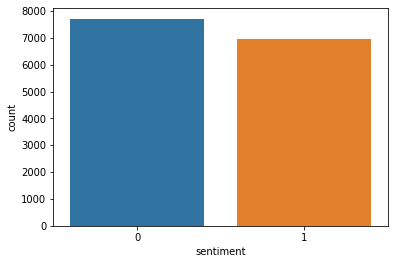

In [11]:
sns.countplot(data['sentiment'])

# 2. Normalize casings for the review text and extract the text into a list for easier manipulation.

In [12]:
reviews = data['review'].values

In [13]:
reviews[:5]

array(['Good but need updates and improvements',
       "Worst mobile i have bought ever, Battery is draining like hell, backup is only 6 to 7 hours with internet uses, even if I put mobile idle its getting discharged.This is biggest lie from Amazon & Lenove which is not at all expected, they are making full by saying that battery is 4000MAH & booster charger is fake, it takes at least 4 to 5 hours to be fully charged.Don't know how Lenovo will survive by making full of us.Please don;t go for this else you will regret like me.",
       'when I will get my 10% cash back.... its already 15 January..',
       'Good',
       'The worst phone everThey have changed the last phone but the problem is still same and the amazon is not returning the phone .Highly disappointing of amazon'],
      dtype=object)

In [14]:
review_lower = [term.lower() for term in reviews]

In [15]:
review_lower[:5]

['good but need updates and improvements',
 "worst mobile i have bought ever, battery is draining like hell, backup is only 6 to 7 hours with internet uses, even if i put mobile idle its getting discharged.this is biggest lie from amazon & lenove which is not at all expected, they are making full by saying that battery is 4000mah & booster charger is fake, it takes at least 4 to 5 hours to be fully charged.don't know how lenovo will survive by making full of us.please don;t go for this else you will regret like me.",
 'when i will get my 10% cash back.... its already 15 january..',
 'good',
 'the worst phone everthey have changed the last phone but the problem is still same and the amazon is not returning the phone .highly disappointing of amazon']

# 3. Tokenize the reviews using NLTKs word_tokenize function.

In [17]:
review_token = [word_tokenize(token) for token in review_lower]

In [18]:
print(review_token[:5])

[['good', 'but', 'need', 'updates', 'and', 'improvements'], ['worst', 'mobile', 'i', 'have', 'bought', 'ever', ',', 'battery', 'is', 'draining', 'like', 'hell', ',', 'backup', 'is', 'only', '6', 'to', '7', 'hours', 'with', 'internet', 'uses', ',', 'even', 'if', 'i', 'put', 'mobile', 'idle', 'its', 'getting', 'discharged.this', 'is', 'biggest', 'lie', 'from', 'amazon', '&', 'lenove', 'which', 'is', 'not', 'at', 'all', 'expected', ',', 'they', 'are', 'making', 'full', 'by', 'saying', 'that', 'battery', 'is', '4000mah', '&', 'booster', 'charger', 'is', 'fake', ',', 'it', 'takes', 'at', 'least', '4', 'to', '5', 'hours', 'to', 'be', 'fully', 'charged.do', "n't", 'know', 'how', 'lenovo', 'will', 'survive', 'by', 'making', 'full', 'of', 'us.please', 'don', ';', 't', 'go', 'for', 'this', 'else', 'you', 'will', 'regret', 'like', 'me', '.'], ['when', 'i', 'will', 'get', 'my', '10', '%', 'cash', 'back', '....', 'its', 'already', '15', 'january', '..'], ['good'], ['the', 'worst', 'phone', 'everthe

# 4. Perform parts-of-speech tagging on each sentence using the NLTK POS tagger.

In [20]:
review_pos = [nltk.pos_tag(sent) for sent in review_token]

In [21]:
print(review_pos[:5])

[[('good', 'JJ'), ('but', 'CC'), ('need', 'VBP'), ('updates', 'NNS'), ('and', 'CC'), ('improvements', 'NNS')], [('worst', 'JJS'), ('mobile', 'NN'), ('i', 'NN'), ('have', 'VBP'), ('bought', 'VBN'), ('ever', 'RB'), (',', ','), ('battery', 'NN'), ('is', 'VBZ'), ('draining', 'VBG'), ('like', 'IN'), ('hell', 'NN'), (',', ','), ('backup', 'NN'), ('is', 'VBZ'), ('only', 'RB'), ('6', 'CD'), ('to', 'TO'), ('7', 'CD'), ('hours', 'NNS'), ('with', 'IN'), ('internet', 'JJ'), ('uses', 'NNS'), (',', ','), ('even', 'RB'), ('if', 'IN'), ('i', 'JJ'), ('put', 'VBP'), ('mobile', 'JJ'), ('idle', 'NN'), ('its', 'PRP$'), ('getting', 'VBG'), ('discharged.this', 'NN'), ('is', 'VBZ'), ('biggest', 'JJS'), ('lie', 'NN'), ('from', 'IN'), ('amazon', 'NN'), ('&', 'CC'), ('lenove', 'NN'), ('which', 'WDT'), ('is', 'VBZ'), ('not', 'RB'), ('at', 'IN'), ('all', 'DT'), ('expected', 'VBN'), (',', ','), ('they', 'PRP'), ('are', 'VBP'), ('making', 'VBG'), ('full', 'JJ'), ('by', 'IN'), ('saying', 'VBG'), ('that', 'DT'), ('bat

# 5. For the topic model, we should  want to include only nouns.

## i. Find out all the POS tags that correspond to nouns.
## ii. Limit the data to only terms with these tags.

In [22]:
nltk.download('tagsets')

[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

In [23]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [24]:
review_nouns = []
for term in review_pos:
    review_nouns.append([token for token in term if re.search('NN.*',token[1])])

In [25]:
print(review_nouns[:5])

[[('updates', 'NNS'), ('improvements', 'NNS')], [('mobile', 'NN'), ('i', 'NN'), ('battery', 'NN'), ('hell', 'NN'), ('backup', 'NN'), ('hours', 'NNS'), ('uses', 'NNS'), ('idle', 'NN'), ('discharged.this', 'NN'), ('lie', 'NN'), ('amazon', 'NN'), ('lenove', 'NN'), ('battery', 'NN'), ('charger', 'NN'), ('hours', 'NNS'), ('don', 'NN')], [('i', 'NN'), ('%', 'NN'), ('cash', 'NN'), ('..', 'NN')], [], [('phone', 'NN'), ('everthey', 'NN'), ('phone', 'NN'), ('problem', 'NN'), ('amazon', 'NN'), ('phone', 'NN'), ('amazon', 'NN')]]


# 6. Lemmatize. 

## i. Different forms of the terms need to be treated as one.
## ii. No need to provide POS tag to lemmatizer for now.

In [28]:
lemmatizer = WordNetLemmatizer()
review_lemma = []
for term in review_nouns:
    review_lemma.append([lemmatizer.lemmatize(sent[0]) for sent in term])

In [29]:
print(review_lemma[:5])

[['update', 'improvement'], ['mobile', 'i', 'battery', 'hell', 'backup', 'hour', 'us', 'idle', 'discharged.this', 'lie', 'amazon', 'lenove', 'battery', 'charger', 'hour', 'don'], ['i', '%', 'cash', '..'], [], ['phone', 'everthey', 'phone', 'problem', 'amazon', 'phone', 'amazon']]


# 7. Remove stopwords and punctuation (if there are any). 

In [31]:
stop_words = stopwords.words('english')

In [32]:
review_nonstopwords = []
for term in review_lemma:
    review_nonstopwords.append([word for word in term if word not in stop_words])

In [33]:
print(review_nonstopwords[:5])

[['update', 'improvement'], ['mobile', 'battery', 'hell', 'backup', 'hour', 'us', 'idle', 'discharged.this', 'lie', 'amazon', 'lenove', 'battery', 'charger', 'hour'], ['%', 'cash', '..'], [], ['phone', 'everthey', 'phone', 'problem', 'amazon', 'phone', 'amazon']]


In [34]:
punct = list(punctuation)

In [35]:
nonpunctuation = []
re_puct = re.compile('[%s]' % re.escape(punctuation))
for sent in review_nonstopwords:
    nonpunctuation.append([re_puct.sub('',word) for word in sent])

In [36]:
nonpunctuation[:5]

[['update', 'improvement'],
 ['mobile',
  'battery',
  'hell',
  'backup',
  'hour',
  'us',
  'idle',
  'dischargedthis',
  'lie',
  'amazon',
  'lenove',
  'battery',
  'charger',
  'hour'],
 ['', 'cash', ''],
 [],
 ['phone', 'everthey', 'phone', 'problem', 'amazon', 'phone', 'amazon']]

In [37]:
remove = []
re_br = re.compile('(br)$')
for term in nonpunctuation:
    remove.append([re_br.sub('',word) for word in term])
    
review_clean = []
for sent in remove:
    review_clean.append([word for word in sent if word.isalpha()])

In [38]:
review_clean[:5]

[['update', 'improvement'],
 ['mobile',
  'battery',
  'hell',
  'backup',
  'hour',
  'us',
  'idle',
  'dischargedthis',
  'lie',
  'amazon',
  'lenove',
  'battery',
  'charger',
  'hour'],
 ['cash'],
 [],
 ['phone', 'everthey', 'phone', 'problem', 'amazon', 'phone', 'amazon']]

# 8. Create a topic model using LDA on the cleaned-up data with 12 topics.

## i. Print out the top terms for each topic.

In [39]:
# Define topics
n_topics = 12

In [40]:
# Create Dictionary
id2word = corpora.Dictionary(review_clean)

#Create corpus
texts = review_clean

In [41]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[50])
print(id2word[1])
print([[(id2word[i],freq) for i, freq in corp] for corp in corpus[:2]])

[(79, 1), (104, 1), (105, 1)]
update
[[('improvement', 1), ('update', 1)], [('amazon', 1), ('backup', 1), ('battery', 2), ('charger', 1), ('dischargedthis', 1), ('hell', 1), ('hour', 2), ('idle', 1), ('lenove', 1), ('lie', 1), ('mobile', 1), ('us', 1)]]


In [42]:
# Build LDA model
lda_model_gensim = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=12,random_state=42,
                                                  passes=10,per_word_topics=True)

In [43]:
# Print the Keyword in the 12 topics
lda_model_gensim.print_topics()

[(0,
  '0.077*"feature" + 0.062*"heat" + 0.051*"superb" + 0.049*"h" + 0.024*"set" + 0.024*"cost" + 0.021*"r" + 0.017*"cell" + 0.011*"k" + 0.010*"fine"'),
 (1,
  '0.093*"phone" + 0.053*"lenovo" + 0.042*"screen" + 0.038*"device" + 0.034*"note" + 0.029*"problem" + 0.027*"option" + 0.025*"service" + 0.022*"day" + 0.019*"star"'),
 (2,
  '0.114*"phone" + 0.075*"price" + 0.073*"amazon" + 0.038*"service" + 0.037*"product" + 0.033*"delivery" + 0.029*"range" + 0.026*"time" + 0.025*"return" + 0.022*"replacement"'),
 (3,
  '0.112*"issue" + 0.112*"phone" + 0.093*"money" + 0.044*"waste" + 0.035*"value" + 0.027*"network" + 0.017*"lot" + 0.016*"worth" + 0.015*"box" + 0.015*"month"'),
 (4,
  '0.256*"problem" + 0.116*"heating" + 0.050*"performance" + 0.023*"network" + 0.019*"excellent" + 0.018*"smartphone" + 0.017*"ok" + 0.016*"everything" + 0.014*"awesome" + 0.013*"connection"'),
 (5,
  '0.257*"battery" + 0.056*"camera" + 0.049*"backup" + 0.042*"phone" + 0.039*"day" + 0.036*"hour" + 0.034*"issue" + 0.0

## ii. What is the coherence of the model with the c_v metric?

In [44]:
# Compute Coherence Score
coherence_lda_gensim = CoherenceModel(model=lda_model_gensim,texts=review_clean,dictionary=id2word,coherence='c_v')

In [45]:
coherence_lda = coherence_lda_gensim.get_coherence()

In [46]:
print('Coherence:',coherence_lda)

Coherence: 0.5265659302002864


In [47]:
# Compute Perplexity for 12 topics
print('Perplexity:',lda_model_gensim.log_perplexity(corpus))

Perplexity: -6.653522184369614


# 9. Analyze the topics through the business lens.

## i. Determine which of the topics can be combined.

In [48]:
x = lda_model_gensim.show_topics(num_topics=12,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
for topic,words in topics_words:
    print(str(topic) + " --> " + str(words))
print()

0 --> ['feature', 'heat', 'superb', 'h', 'set', 'cost', 'r', 'cell', 'k', 'fine']
1 --> ['phone', 'lenovo', 'screen', 'device', 'note', 'problem', 'option', 'service', 'day', 'star']
2 --> ['phone', 'price', 'amazon', 'service', 'product', 'delivery', 'range', 'time', 'return', 'replacement']
3 --> ['issue', 'phone', 'money', 'waste', 'value', 'network', 'lot', 'worth', 'box', 'month']
4 --> ['problem', 'heating', 'performance', 'network', 'excellent', 'smartphone', 'ok', 'everything', 'awesome', 'connection']
5 --> ['battery', 'camera', 'backup', 'phone', 'day', 'hour', 'issue', 'life', 'time', 'performance']
6 --> ['charger', 'call', 'volta', 'turbo', 'condition', 'month', 'piece', 'speed', 'message', 'notification']
7 --> ['phone', 'hai', 'ho', 'plz', 'hi', 'month', 'color', 'bhi', 'hang', 'charge']
8 --> ['mobile', 'speaker', 'glass', 'gorilla', 'display', 'class', 'work', 'screen', 'cover', 'gud']
9 --> ['note', 'sim', 'network', 'phone', 'system', 'call', 'card', 'sensor', 'jio',

Coherence measures the interpretability of the topics. Good value for Coherence measure c_V is 0.5.

Topic 5 and 6 are vaguely about the battery life and charger.

Topic 3 and 4 are vaguely about the product heating and problems.

Topic 8, 9 and 11 are vaguely about the product functions.

Above topics can be combined. 

After we combined some topics, we are left with 8 topics. Lets repeat the LDA for 8 topics and see the result.

# 10. Create a topic model using LDA with what you think is the optimal number of topics

In [49]:
# Build LDA model with 8 topics 
lda_model_8 = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=8,random_state=42,passes=10,
                                             per_word_topics=True)

In [50]:
# Print the Keyword in the 12 topics
lda_model_8.print_topics()

[(0,
  '0.170*"mobile" + 0.050*"charger" + 0.044*"feature" + 0.029*"device" + 0.026*"battery" + 0.023*"turbo" + 0.018*"hour" + 0.017*"charging" + 0.015*"day" + 0.013*"issue"'),
 (1,
  '0.073*"phone" + 0.039*"service" + 0.032*"screen" + 0.024*"problem" + 0.020*"amazon" + 0.020*"product" + 0.019*"day" + 0.019*"speaker" + 0.018*"option" + 0.017*"lenovo"'),
 (2,
  '0.163*"product" + 0.083*"price" + 0.082*"phone" + 0.030*"range" + 0.026*"amazon" + 0.022*"delivery" + 0.019*"feature" + 0.017*"superb" + 0.017*"return" + 0.017*"glass"'),
 (3,
  '0.091*"money" + 0.056*"issue" + 0.043*"waste" + 0.034*"value" + 0.030*"update" + 0.027*"h" + 0.027*"software" + 0.026*"system" + 0.021*"box" + 0.017*"work"'),
 (4,
  '0.178*"problem" + 0.052*"heating" + 0.034*"hai" + 0.019*"network" + 0.017*"please" + 0.014*"ho" + 0.014*"excellent" + 0.013*"smartphone" + 0.011*"plz" + 0.009*"message"'),
 (5,
  '0.191*"camera" + 0.098*"battery" + 0.081*"quality" + 0.039*"performance" + 0.034*"backup" + 0.016*"mode" + 0.0

## i. What is the coherence of the model?

In [51]:
# Compute Coherence Score for 8 topics
coherence_lda_gensim = CoherenceModel(model=lda_model_8,texts=review_clean,dictionary=id2word,coherence='c_v')

In [52]:
coherence_lda = coherence_lda_gensim.get_coherence()

In [53]:
print('Coherence:',coherence_lda)

Coherence: 0.5724932854996856


In [54]:
# Compute Perplexity for 8 topics
print('Perplexity:',lda_model_8.log_perplexity(corpus))

Perplexity: -6.585275005141235


# 11. The business should be able to interpret the topics.

## i. Name each of the identified topics.

In [55]:
x = lda_model_8.show_topics(formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
for topic,words in topics_words:
    print(str(topic)+ "::"+ str(words))
print()

0::['mobile', 'charger', 'feature', 'device', 'battery', 'turbo', 'hour', 'charging', 'day', 'issue']
1::['phone', 'service', 'screen', 'problem', 'amazon', 'product', 'day', 'speaker', 'option', 'lenovo']
2::['product', 'price', 'phone', 'range', 'amazon', 'delivery', 'feature', 'superb', 'return', 'glass']
3::['money', 'issue', 'waste', 'value', 'update', 'h', 'software', 'system', 'box', 'work']
4::['problem', 'heating', 'hai', 'network', 'please', 'ho', 'excellent', 'smartphone', 'plz', 'message']
5::['camera', 'battery', 'quality', 'performance', 'backup', 'mode', 'display', 'sound', 'everything', 'depth']
6::['note', 'phone', 'lenovo', 'network', 'call', 'sim', 'feature', 'card', 'jio', 'stock']
7::['phone', 'battery', 'issue', 'time', 'day', 'month', 'hour', 'heat', 'life', 'use']



## ii. Create a table with the topic name and the top 10 terms in each to present to the business.

## Topic - Business Name

Topic 0 :- Battery Related

Topic 1 :- Customer Service

Topic 2 :- Performace of eshopping platform

Topic 3 :- Feedback of the product

Topic 4 :- Features on which pricing depend

Topic 5 :- Option to be considere for shopping

Topic 6 :- Related to Communication or connectivity

Topic 7 :- Phone Performance